# Sushi detection with Yolo v11

In [ ]:
!pip install ultralytics --no-deps

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Raw data conversion to Yolo format

In [2]:
import pandas as pd
from pathlib import Path
import requests
import glob
from concurrent.futures import ThreadPoolExecutor

IMAGE_SCRAPER_RAW_DATA_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/image-scraper-raw-data")


def filter_valid(urls):
    with ThreadPoolExecutor(max_workers=50) as executor:
        results = list(executor.map(is_valid_url, urls))
    return [u for u, ok in zip(urls, results) if ok]
# Folder with your CSVs

def is_valid_url(url: str) -> bool:
    try:
        r = requests.head(url, allow_redirects=True, timeout=5)
        if r.status_code == 405:  # some servers reject HEAD
            r = requests.get(url, stream=True, timeout=5)
        return r.status_code == 200
    except requests.RequestException:
        return False

all_dicts = {}

for csv_file in IMAGE_SCRAPER_RAW_DATA_DIR.glob("*.csv"):
    df = pd.read_csv(csv_file, names=['path'], header=None)
    valid_urls = filter_valid(df['path'].tolist())
    all_dicts[csv_file.stem] = valid_urls
    print(f"✅ {csv_file.name}: {len(valid_urls)} valid URLs out of {len(df)}")

# Now all_dicts has the structure you want
print("\nFinished!\n")
print(all_dicts.keys())  # just to see which CSVs were processed

✅ amberjack.csv: 44 valid URLs out of 80
✅ salmon.csv: 48 valid URLs out of 80
✅ halibut fin.csv: 44 valid URLs out of 80
✅ ark clam.csv: 37 valid URLs out of 80
✅ mackerel.csv: 47 valid URLs out of 80
✅ sea urchin.csv: 47 valid URLs out of 80
✅ squid.csv: 51 valid URLs out of 80
✅ octopus.csv: 40 valid URLs out of 80
✅ shrimp.csv: 61 valid URLs out of 80
✅ shad.csv: 14 valid URLs out of 28
✅ salmon roe.csv: 51 valid URLs out of 80
✅ crab.csv: 49 valid URLs out of 80
✅ spanish mackerel.csv: 44 valid URLs out of 80
✅ bonito.csv: 34 valid URLs out of 80
✅ fatty tuna.csv: 16 valid URLs out of 28
✅ sea bream.csv: 16 valid URLs out of 28
✅ tuna.csv: 50 valid URLs out of 80
✅ sardine.csv: 41 valid URLs out of 80
✅ sea eel.csv: 18 valid URLs out of 28
✅ yellowtail fish.csv: 16 valid URLs out of 28
✅ surf clam.csv: 50 valid URLs out of 80
✅ eel.csv: 39 valid URLs out of 80
✅ scallop.csv: 16 valid URLs out of 28
✅ whelk.csv: 37 valid URLs out of 80
✅ egg.csv: 46 valid URLs out of 80

Finished!


In [18]:
!pip -q install "transformers>=4.41" "accelerate>=0.30" timm supervision \
  opencv-python-headless pillow torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121

In [18]:
# Remove files in data folder
import shutil

# Paths
IMG_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/train/images")
LBL_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/train/labels")

# Clean up existing folders
for d in [IMG_DIR, LBL_DIR]:
    if d.exists():
        shutil.rmtree(d)   # deletes the folder and everything inside
    d.mkdir(parents=True, exist_ok=True)

In [19]:
from pathlib import Path
import cv2, torch, requests, numpy as np
import supervision as sv
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# ------------------------------
# Classes (jp/en/url) as provided
# ------------------------------
CLASSES = [
  {'jp': 'サーモン', 'en': 'salmon', 'url': "http://www.sushiencyclopedia.com/sushi-fish/salmon.html"},
  {'jp': 'マグロ', 'en': 'tuna', 'url': "http://www.sushiencyclopedia.com/sushi-fish/tuna.html"},
  {'jp': 'さば', 'en': 'mackerel', 'url': "http://www.sushiencyclopedia.com/sushi-fish/mackerel.html"},
  {'jp': 'アジ', 'en': 'spanish mackerel', 'url': "http://www.sushiencyclopedia.com/sushi-fish/spanish_mackerel.html"},
  {'jp': 'アナゴ', 'en': 'sea eel', 'url': "http://www.sushiencyclopedia.com/sushi-fish/sea-eel.html"},
  {'jp': 'ウナギ', 'en': 'eel', 'url': "http://www.sushiencyclopedia.com/sushi-fish/eel.html"},
  {'jp': '卵', 'en': 'egg', 'url': "http://www.sushiencyclopedia.com/sushi-menu/egg_sushi.html"},
  {'jp': 'いくら', 'en': 'salmon roe', 'url': "http://www.sushiencyclopedia.com/sushi-menu/salmon_roe_sushi.html"},
  {'jp': 'えび', 'en': 'shrimp', 'url': "http://www.sushiencyclopedia.com/sushi-menu/shrimp_sushi.html"},
  {'jp': '鯛', 'en': 'sea bream', 'url': "http://www.sushiencyclopedia.com/sushi-fish/red_snapper.html"},
  {'jp': 'つぶ貝', 'en': 'whelk', 'url': "https://en.wikipedia.org/wiki/Whelk"},
  {'jp': 'ブリ', 'en': 'yellowtail fish', 'url': "http://www.sushiencyclopedia.com/sushi-fish/yellowtail-amberjack.html"},
  {'jp': 'ホッキ貝', 'en': 'surf clam', 'url': "https://www.sushifaq.com/sushi-sashimi-info/sushi-item-profiles/akagai-surf-clam/"},
  {'jp': '縁側', 'en': 'halibut fin', 'url': "http://www.sushiencyclopedia.com/sushi-fish/halibut.html"},
  {'jp': 'たこ', 'en': 'octopus', 'url': "http://www.sushiencyclopedia.com/sushi-other-seafood/octopus.html"},
  {'jp': 'イカ', 'en': 'squid', 'url': "http://www.sushiencyclopedia.com/sushi-menu/squid-sushi.html"},
  {'jp': 'カンパチ', 'en': 'amberjack', 'url': "http://www.sushiencyclopedia.com/sushi-fish/amberjack.html"},
  {'jp': 'イワシ', 'en': 'sardine', 'url': "http://www.sushiencyclopedia.com/sushi-fish/sardine.html"},
  {'jp': 'ウニ', 'en': 'sea urchin', 'url': "https://www.sushifaq.com/sushi-sashimi-info/sushi-item-profiles/sushi-items-uni-sea-urchin/"},
  {'jp': 'ホタテ', 'en': 'scallop', 'url': "https://www.justonecookbook.com/scallop-sushi/"},
  {'jp': '赤貝', 'en': 'ark clam', 'url': "http://www.sushiencyclopedia.com/sushi-shellfish/ark-shell-clam.html"},
  {'jp': 'かに', 'en': 'crab', 'url': "https://www.sushifaq.com/sushi-sashimi-info/sushi-item-profiles/kanikama-or-surimi/"},
  {'jp': 'カツオ', 'en': 'bonito', 'url': "http://www.sushiencyclopedia.com/sushi-fish/bonito.html"},
  {'jp': '小肌', 'en': 'shad', 'url': "http://www.sushiencyclopedia.com/sushi-menu/gizzard_shad_sushi.html"},
  {'jp': '大トロ', 'en': 'fatty tuna', 'url': "http://www.sushiencyclopedia.com/sushi-menu/toro-tuna-belly-sushi.html"}
]

# Names (we'll use English as canonical class keys)
classes = [c['en'] for c in CLASSES]
name2id = {n: i for i, n in enumerate(classes)}

# Optional: alias mapping to normalize keys coming from all_dicts
ALIASES = {
    "otoro": "fatty tuna",
    "o-toro": "fatty tuna",
    "toro": "fatty tuna",
    "hamachi": "yellowtail fish",
    "buri": "yellowtail fish",
    "kanpachi": "amberjack",
    "akami": "tuna",
    "chutoro": "tuna",
    "kohada": "shad",
    "red snapper": "sea bream",
    "ikura": "salmon roe",
    "tamago": "egg",
    "unagi": "eel",
    "anago": "sea eel",
    "hokkigai": "surf clam",
    "akagai": "ark clam",
    "engawa": "halibut fin",
    "ebi": "shrimp",
    "ika": "squid",
    "tako": "octopus",
}

def normalize_key(k: str) -> str:
    k = k.strip().lower()
    return ALIASES.get(k, k)

# ------------------------------
# Prompt builder per class
# ------------------------------
def make_prompts():
    P = {}
    P["salmon"] = ["salmon nigiri","salmon sushi","sake nigiri","sake sushi"]
    P["tuna"] = ["tuna nigiri","maguro nigiri","akami nigiri","chutoro nigiri","tuna sushi"]
    P["mackerel"] = ["mackerel nigiri","saba nigiri","mackerel sushi"]
    P["spanish mackerel"] = ["spanish mackerel nigiri","aji nigiri","aji sushi"]
    P["sea eel"] = ["sea eel nigiri","anago nigiri","anago sushi"]
    P["eel"] = ["eel nigiri","unagi nigiri","unagi sushi","grilled eel nigiri"]
    P["egg"] = ["egg nigiri","tamago nigiri","omelette nigiri","tamago sushi"]
    P["salmon roe"] = ["ikura gunkan","salmon roe gunkan","ikura sushi","salmon roe sushi"]
    P["shrimp"] = ["shrimp nigiri","ebi nigiri","ebi sushi"]
    P["sea bream"] = ["sea bream nigiri","tai nigiri","red snapper nigiri","tai sushi"]
    P["whelk"] = ["whelk nigiri","tsubugai nigiri","whelk sushi"]
    P["yellowtail fish"] = ["yellowtail nigiri","hamachi nigiri","buri nigiri","yellowtail sushi"]
    P["surf clam"] = ["surf clam nigiri","hokkigai nigiri","surf clam sushi"]
    P["halibut fin"] = ["halibut fin nigiri","engawa nigiri","engawa sushi"]
    P["octopus"] = ["octopus nigiri","tako nigiri","octopus sushi"]
    P["squid"] = ["squid nigiri","ika nigiri","squid sushi"]
    P["amberjack"] = ["amberjack nigiri","kanpachi nigiri","amberjack sushi"]
    P["sardine"] = ["sardine nigiri","iwashi nigiri","sardine sushi"]
    P["sea urchin"] = ["uni gunkan","sea urchin gunkan","uni sushi","sea urchin sushi"]
    P["scallop"] = ["scallop nigiri","hotate nigiri","scallop sushi"]
    P["ark clam"] = ["ark clam nigiri","akagai nigiri","ark clam sushi"]
    P["crab"] = ["crab nigiri","kani nigiri","crab sushi"]
    P["bonito"] = ["bonito nigiri","katsuo nigiri","bonito sushi"]
    P["shad"] = ["gizzard shad nigiri","kohada nigiri","shad sushi"]
    P["fatty tuna"] = ["fatty tuna nigiri","toro nigiri","otoro nigiri","chu-toro nigiri"]
    # Default: if any class not covered above, fall back
    for en in classes:
        if en not in P:
            P[en] = [f"{en} nigiri", f"{en} sushi"]
    return P

prompts = make_prompts()

# ------------------------------
# OWL-ViT model
# ------------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(DEVICE).eval()

BOX_THR = 0.30
NMS_IOU = 0.5
MAX_LONG_SIDE = 1280

IMG_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/train/images")
IMG_DIR.mkdir(parents=True, exist_ok=True)

def imread_any(path_or_url: str, class_name: str = None):
    if str(path_or_url).startswith(("http://","https://")):
        r = requests.get(path_or_url, timeout=10)
        r.raise_for_status()
        arr = np.frombuffer(r.content, dtype=np.uint8)
        img = cv2.imdecode(arr, cv2.IMREAD_COLOR)

        # Save a copy in IMG_DIR
        if img is not None:
            # give filename based on url tail, optionally prefix with class
            name = Path(path_or_url).stem.split("?q=")[1]  # clean name
            if class_name:
                name = f"{class_name}_{name}"
            out_path = IMG_DIR / f"{name}.jpg"
            cv2.imwrite(str(out_path), img)
        return (img, name)
    else:
        img = cv2.imread(str(path_or_url))
        # also copy local images into IMG_DIR for consistency
        if img is not None:
            name = Path(path_or_url).stem
            out_path = IMG_DIR / f"{name}.jpg"
            cv2.imwrite(str(out_path), img)
        return (img, name)

def resize_long_side(img, max_side=1280):
    h, w = img.shape[:2]
    m = max(h, w)
    if m <= max_side:
        return img, 1.0
    s = max_side / m
    return cv2.resize(img, (int(w*s), int(h*s))), s

def to_yolo(xyxy, w, h):
    x1,y1,x2,y2 = xyxy
    bw, bh = x2-x1, y2-y1
    cx, cy = x1 + bw/2, y1 + bh/2
    return cx/w, cy/h, bw/w, bh/h

BOX_THR = 0.30
NMS_IOU = 0.5
MAX_LONG_SIDE = 1280

@torch.inference_mode()
def owl_predict(img_bgr, texts):
    """
    Returns (boxes[N,4], scores[N], labels[N])
    Uses the new grounded postprocess if available, otherwise falls back.
    """
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    inputs = processor(text=texts, images=rgb, return_tensors="pt").to(DEVICE)
    outputs = model(**inputs)
    target_sizes = torch.tensor([rgb.shape[:2]]).to(DEVICE)  # (h, w)

    # Try new API first
    try:
        results = processor.post_process_grounded_object_detection(
            outputs=outputs,
            target_sizes=target_sizes,
            text_queries=texts,        # list[str]
            threshold=BOX_THR,
        )[0]
    except Exception:
        # Fallback to old API (silences your FutureWarning)
        results = processor.post_process_object_detection(
            outputs=outputs,
            target_sizes=target_sizes,
            threshold=BOX_THR,
        )[0]

    boxes  = results.get("boxes",  torch.empty((0,4), device=DEVICE)).detach().cpu().numpy()
    scores = results.get("scores", torch.empty((0,),   device=DEVICE)).detach().cpu().numpy()
    labels = results.get("labels", torch.empty((0,),   device=DEVICE, dtype=torch.long)).detach().cpu().numpy()
    return boxes, scores, labels

def apply_nms_with_supervision(dets, iou=NMS_IOU, class_agnostic=False):
    """
    supervision>=0.21 changed signature of with_nms.
    Try keyword, then positional; if both fail, return dets unchanged.
    """
    try:
        return dets.with_nms(class_agnostic=class_agnostic, iou_threshold=iou)
    except TypeError:
        try:
            return dets.with_nms(iou, class_agnostic=class_agnostic)  # positional iou
        except TypeError:
            return dets

# -------------------------------------------------
# Main loop — uses single prompt set for known class
# -------------------------------------------------
# Expecting: all_dicts = { 'salmon': [url_or_path,...], 'fatty tuna': [...], ... }
LBL_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/train/labels"); LBL_DIR.mkdir(parents=True, exist_ok=True)

for raw_class_name, paths in all_dicts.items():
    key = normalize_key(raw_class_name)
    if key not in name2id and key in ALIASES:
        key = ALIASES[key]
    if key not in name2id:
        print(f"[warn] Unknown class key from all_dicts: '{raw_class_name}' -> '{key}'. Skipping.")
        continue

    cls_id = name2id[key]
    texts = prompts[key]

    for p in paths:
        img, filename = imread_any(p, key)
        if img is None:
            print("No image!")
            continue

        H, W = img.shape[:2]
        img_in, scale = resize_long_side(img, MAX_LONG_SIDE)

        boxes, scores, _labels = owl_predict(img_in, texts)
        if boxes.shape[0] == 0:
            continue

        if scale != 1.0:
            boxes = boxes / scale  # back to original size

        dets = sv.Detections(
            xyxy=boxes,
            confidence=scores,
            class_id=np.full(len(boxes), cls_id, dtype=int)
        )
        dets = apply_nms_with_supervision(dets, iou=NMS_IOU, class_agnostic=False)

        # sanity checks + write YOLO labels
        lines = []
        for (x1,y1,x2,y2), c, k in zip(dets.xyxy, dets.confidence, dets.class_id):
            bw, bh = (x2-x1), (y2-y1)
            area = (bw*bh)/(W*H)
            if area < 0.0005 or area > 0.8:
                continue
            cx, cy, ww, hh = to_yolo((x1,y1,x2,y2), W, H)
            lines.append(f"{int(k)} {cx:.6f} {cy:.6f} {ww:.6f} {hh:.6f}")

        if lines:
            (LBL_DIR / f"{filename}.txt").write_text("\n".join(lines))

In [20]:
# Remove files in data folder
import shutil

# Paths
IMG_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/valid/images")
LBL_DIR = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data/valid/labels")

# Clean up existing folders
for d in [IMG_DIR, LBL_DIR]:
    if d.exists():
        shutil.rmtree(d)   # deletes the folder and everything inside
    d.mkdir(parents=True, exist_ok=True)

# Take 20% of data and move it to the valid folder

import os, random, shutil
from pathlib import Path

# Base paths
BASE = Path("/content/drive/MyDrive/yolo-sushi-detection-data/data")
TRAIN_IMG = BASE / "train/images"
TRAIN_LBL = BASE / "train/labels"
VALID_IMG = BASE / "valid/images"
VALID_LBL = BASE / "valid/labels"

# Make sure valid dirs exist
VALID_IMG.mkdir(parents=True, exist_ok=True)
VALID_LBL.mkdir(parents=True, exist_ok=True)

# List image files (assume images are .jpg or .png)
img_exts = {".jpg", ".jpeg", ".png", ".bmp"}
train_images = [f for f in TRAIN_IMG.iterdir() if f.suffix.lower() in img_exts]

print(f"Total train images: {len(train_images)}")
print(f"Total train labels: {len(list(TRAIN_LBL.glob('*.txt')))}")

# Take 20%
valid_count = int(len(train_images) * 0.2)
valid_samples = random.sample(train_images, valid_count)

print(f"Moving {valid_count} samples to valid set...")

for img_path in valid_samples:
    # Corresponding label
    label_path = TRAIN_LBL / (img_path.stem + ".txt")

    # Move image
    shutil.move(str(img_path), str(VALID_IMG / img_path.name))

    # Move label (if exists)
    if label_path.exists():
        shutil.move(str(label_path), str(VALID_LBL / label_path.name))

print("✅ Done!")
print(f"Now train has {len(list(TRAIN_IMG.glob('*')))} images, valid has {len(list(VALID_IMG.glob('*')))} images.")

Total train images: 956
Total train labels: 9
Moving 191 samples to valid set...
✅ Done!
Now train has 765 images, valid has 191 images.


In [ ]:
from pathlib import Path

DATA = "/content/drive/MyDrive/yolo-susho-detection-data"  # adjust if needed

def seg2box_line(line):
    parts = list(map(float, line.strip().split()))
    cls, coords = int(parts[0]), parts[1:]
    xs = coords[0::2]
    ys = coords[1::2]
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)
    # Convert to YOLO (cx, cy, w, h), all already normalized 0–1
    x_c = (xmin + xmax) / 2
    y_c = (ymin + ymax) / 2
    w   = xmax - xmin
    h   = ymax - ymin
    return f"{cls} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}"

def convert_folder(root):
    lbls = list(Path(root,"labels").rglob("*.txt"))
    for p in lbls:
        new_lines = []
        for line in open(p):
            parts = line.strip().split()
            if len(parts) > 5:  # segmentation line
                new_lines.append(seg2box_line(line))
            else:  # already YOLO box line
                new_lines.append(line.strip())
        with open(p,"w") as f:
            f.write("\n".join(new_lines))

# Convert both train and valid
for split in ("train","valid"):
    convert_folder(Path(DATA, split))

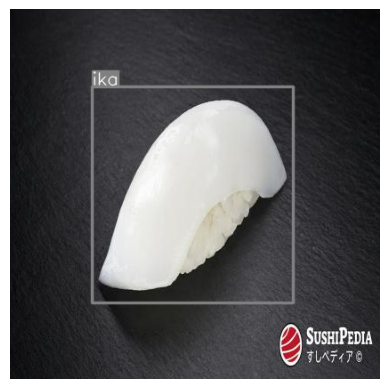

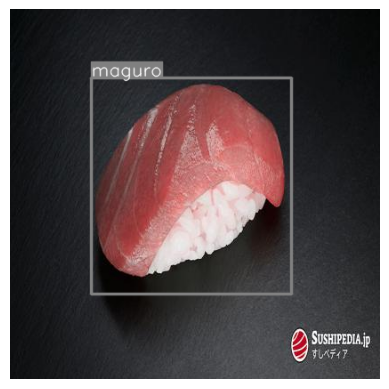

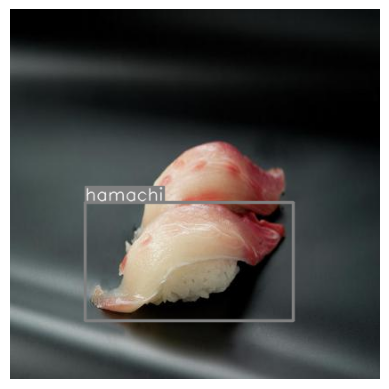

In [ ]:
import cv2, random
from ultralytics.utils.plotting import Annotator
from matplotlib import pyplot as plt

def show_gt(img_path: Path, names):
    im = cv2.imread(str(img_path))
    H,W = im.shape[:2]
    lbl = Path(str(img_path).replace("/images/","/labels/")).with_suffix(".txt")
    ann = Annotator(im.copy(), line_width=2)
    if lbl.exists():
        for line in open(lbl):
            c,x,y,w,h = map(float, line.split())
            c=int(c)
            x1=int((x-w/2)*W); y1=int((y-h/2)*H)
            x2=int((x+w/2)*W); y2=int((y+h/2)*H)
            ann.box_label([x1,y1,x2,y2], names[c])
    plt.imshow(cv2.cvtColor(ann.result(), cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()

import yaml, glob
names = yaml.safe_load(open(YAML))["names"]
sample_imgs = glob.glob(f"{DATA}/valid/images/*")
for p in random.sample(sample_imgs, min(3, len(sample_imgs))):
    show_gt(Path(p), names)

In [ ]:
model = YOLO("yolo11n.pt")

In [ ]:
results = model.train(
    data="/content/drive/MyDrive/yolo-susho-detection-data/data.yaml",
    epochs=80,
    batch=4,
    imgsz=416,
    model="yolo11n.pt",
    patience=20,
    seed=0
)

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo-susho-detection-data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train533, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, pl

train: Scanning /content/drive/MyDrive/yolo-susho-detection-data/train/labels... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 149.31it/s]

train: New cache created: /content/drive/MyDrive/yolo-susho-detection-data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 9.3±4.9 MB/s, size: 19.8 KB)


val: Scanning /content/drive/MyDrive/yolo-susho-detection-data/valid/labels... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 79.34it/s]

val: New cache created: /content/drive/MyDrive/yolo-susho-detection-data/valid/labels.cache


Plotting labels to runs/detect/train533/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000385, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train533
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80     0.432G      1.761      4.279      1.969          2        416: 100%|██████████| 18/18 [00:03<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]

                   all         18         18     0.0288      0.529      0.229     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80     0.432G       1.62      4.213      1.897          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.11it/s]

                   all         18         18     0.0199      0.824      0.126     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80     0.432G      1.657      4.188      1.922          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


                   all         18         18     0.0124      0.824      0.117     0.0603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80     0.432G      1.523      4.116      1.809          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.21it/s]


                   all         18         18     0.0152      0.882      0.158      0.071

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80     0.432G      1.599      4.202      1.876          4        416: 100%|██████████| 18/18 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.95it/s]

                   all         18         18     0.0103      0.824      0.134     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80     0.432G        1.5      4.175      1.819          1        416: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.27it/s]

                   all         18         18    0.00935      0.824      0.136     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80     0.432G      1.555      4.109      1.847          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.31it/s]


                   all         18         18    0.00933      0.824       0.13     0.0698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80     0.432G      1.528      4.089      1.766          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.23it/s]


                   all         18         18    0.00899      0.824      0.133     0.0712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80     0.432G      1.495      4.103      1.732          4        416: 100%|██████████| 18/18 [00:01<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.24it/s]

                   all         18         18     0.0101      0.882       0.13     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80     0.432G      1.512      4.104      1.797          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.13it/s]


                   all         18         18     0.0112      0.882       0.16      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80     0.439G      1.421       4.05       1.73          3        416: 100%|██████████| 18/18 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.38it/s]


                   all         18         18     0.0105      0.824      0.155      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80     0.439G      1.359      4.087      1.726          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.00it/s]

                   all         18         18     0.0105      0.824      0.115     0.0724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80     0.439G      1.477       4.05       1.81          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


                   all         18         18     0.0133          1      0.133     0.0806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80     0.439G      1.351      4.028      1.704          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


                   all         18         18     0.0112      0.941      0.129     0.0822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80     0.439G       1.35       3.98      1.705          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.72it/s]

                   all         18         18      0.011      0.941      0.152     0.0842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80     0.439G      1.394       4.02      1.739          3        416: 100%|██████████| 18/18 [00:02<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.05it/s]

                   all         18         18     0.0102      0.941      0.153     0.0844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80     0.439G      1.408      3.977       1.72          4        416: 100%|██████████| 18/18 [00:01<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.42it/s]


                   all         18         18     0.0111      0.941      0.164     0.0905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80     0.439G      1.356      3.987      1.681          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.31it/s]


                   all         18         18     0.0117      0.941      0.228      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80     0.439G      1.458      4.076      1.747          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.87it/s]


                   all         18         18     0.0106      0.941      0.151     0.0876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80     0.439G      1.308      3.935      1.686          4        416: 100%|██████████| 18/18 [00:01<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.74it/s]


                   all         18         18      0.011      0.941      0.116     0.0794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80     0.455G      1.341       3.95      1.642          4        416: 100%|██████████| 18/18 [00:02<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]


                   all         18         18     0.0104      0.941      0.109     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80     0.469G      1.304      3.909      1.655          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.15it/s]

                   all         18         18     0.0101      0.941      0.107      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80     0.471G      1.413      3.976      1.741          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.93it/s]

                   all         18         18      0.386      0.206      0.104      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80     0.471G        1.3      3.946       1.61          4        416: 100%|██████████| 18/18 [00:01<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


                   all         18         18     0.0095      0.941     0.0911     0.0604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80     0.471G      1.373      3.972      1.682          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.88it/s]

                   all         18         18     0.0104      0.941      0.102     0.0708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80     0.471G      1.321      3.837      1.651          4        416: 100%|██████████| 18/18 [00:02<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.25it/s]

                   all         18         18       0.55      0.179      0.109     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80     0.471G      1.263      3.898      1.636          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.27it/s]


                   all         18         18      0.547      0.143      0.105     0.0734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80     0.471G      1.274      3.917      1.622          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.37it/s]

                   all         18         18      0.667      0.118      0.118     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80     0.471G      1.309      3.864      1.621          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


                   all         18         18      0.667      0.118      0.167      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80     0.471G      1.168      3.786      1.571          1        416: 100%|██████████| 18/18 [00:01<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


                   all         18         18      0.542      0.118      0.139      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80     0.471G      1.167      3.754      1.549          1        416: 100%|██████████| 18/18 [00:02<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.95it/s]

                   all         18         18      0.545      0.125      0.124     0.0887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80     0.471G      1.158      3.789       1.53          3        416: 100%|██████████| 18/18 [00:02<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


                   all         18         18      0.666      0.118      0.178      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80     0.471G      1.218      3.731      1.648          1        416: 100%|██████████| 18/18 [00:01<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.27it/s]


                   all         18         18      0.667      0.118      0.177      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80     0.471G      1.237      3.712      1.599          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


                   all         18         18       0.67      0.118      0.207      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80     0.471G      1.347      3.914      1.656          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.09it/s]

                   all         18         18      0.603      0.118      0.201      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80     0.471G      1.295      3.779       1.64          2        416: 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.78it/s]

                   all         18         18      0.543      0.118      0.191      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80     0.471G      1.108      3.762      1.501          4        416: 100%|██████████| 18/18 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


                   all         18         18      0.545      0.118      0.191      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80     0.471G      1.231      3.731      1.562          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


                   all         18         18      0.605      0.118      0.181      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80     0.471G      1.196      3.707      1.581          2        416: 100%|██████████| 18/18 [00:01<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.06it/s]

                   all         18         18      0.548      0.118      0.174      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80     0.471G      1.091       3.67      1.477          4        416: 100%|██████████| 18/18 [00:02<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.41it/s]


                   all         18         18      0.511      0.176       0.21      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80     0.471G      1.231      3.692      1.606          1        416: 100%|██████████| 18/18 [00:02<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.09it/s]

                   all         18         18       0.52      0.176      0.222      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80     0.471G      1.133      3.625      1.508          1        416: 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.60it/s]


                   all         18         18      0.496      0.176      0.221      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80     0.471G      1.153      3.654      1.525          4        416: 100%|██████████| 18/18 [00:01<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.88it/s]

                   all         18         18      0.655      0.176      0.223      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80     0.471G      1.043      3.644      1.438          0        416: 100%|██████████| 18/18 [00:01<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.93it/s]


                   all         18         18       0.67      0.176       0.24      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80     0.471G      1.237      3.653      1.568          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.55it/s]


                   all         18         18      0.675      0.176      0.257      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80     0.471G      1.147      3.651      1.493          3        416: 100%|██████████| 18/18 [00:02<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.94it/s]

                   all         18         18      0.672      0.176      0.251      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80     0.471G      1.162      3.659      1.556          1        416: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.94it/s]


                   all         18         18      0.657      0.176      0.246        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80     0.471G      1.222      3.608      1.564          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


                   all         18         18      0.659      0.175       0.25      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80     0.471G      1.181      3.619      1.534          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.96it/s]


                   all         18         18      0.657      0.166      0.243      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80     0.471G      1.182      3.602      1.518          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.84it/s]


                   all         18         18      0.716      0.118      0.236      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80     0.471G      1.167       3.62      1.518          2        416: 100%|██████████| 18/18 [00:02<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]

                   all         18         18      0.655      0.118      0.235      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80     0.471G       1.08      3.556      1.431          4        416: 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


                   all         18         18      0.651      0.165      0.243      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80     0.471G      1.143      3.617      1.526          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.42it/s]

                   all         18         18      0.651      0.118      0.239       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80     0.471G      1.176      3.559       1.55          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


                   all         18         18       0.65      0.152      0.244      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80     0.471G      1.175      3.546      1.481          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


                   all         18         18      0.648      0.161      0.242      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80     0.471G      1.024      3.469      1.433          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.98it/s]

                   all         18         18      0.708      0.153      0.234      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80     0.471G      1.181      3.676      1.517          2        416: 100%|██████████| 18/18 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.00it/s]

                   all         18         18      0.333      0.352      0.236      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80     0.471G      1.063      3.447      1.477          2        416: 100%|██████████| 18/18 [00:01<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


                   all         18         18      0.703      0.176      0.237      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80     0.471G      1.153      3.506      1.501          1        416: 100%|██████████| 18/18 [00:01<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.48it/s]


                   all         18         18      0.707      0.176      0.243      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80     0.471G      1.134      3.479      1.476          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.52it/s]

                   all         18         18      0.724      0.176      0.242      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80     0.471G      1.111      3.511      1.476          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.36it/s]


                   all         18         18      0.728      0.176      0.243      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80     0.471G      1.064      3.434      1.443          4        416: 100%|██████████| 18/18 [00:02<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.36it/s]


                   all         18         18      0.713      0.176      0.237       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80     0.471G      1.106      3.409      1.491          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.96it/s]

                   all         18         18      0.714      0.176       0.24      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80     0.471G      1.093      3.514      1.438          4        416: 100%|██████████| 18/18 [00:01<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


                   all         18         18      0.796      0.175      0.253      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80     0.471G      1.134      3.518      1.477          3        416: 100%|██████████| 18/18 [00:01<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.23it/s]

                   all         18         18      0.332      0.304      0.248      0.198


EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 45, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

65 epochs completed in 0.048 hours.
Optimizer stripped from runs/detect/train533/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train533/weights/best.pt, 5.5MB

Validating runs/detect/train533/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,586,442 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.36it/s]


                   all         18         18      0.675      0.176      0.257      0.208
                 anago          1          1          1          0     0.0474    0.00474
                   ebi          1          1          1          0          0          0
              futomaki          1          1          0          0    0.00985    0.00454
               hamachi          1          1          0          0      0.124     0.0416
              hokkigai          1          1          1          0      0.166      0.116
                   ika          1          1          1          0      0.995      0.895
                 ikura          1          1      0.456          1      0.497      0.398
                  kani          1          1          1          0      0.332      0.298
                maguro          1          1      0.247          1      0.332      0.298
                masago          2          2          0          0      0.159      0.143
          philadelphi

In [ ]:
# Validate on your val set
model.val(data="/content/drive/MyDrive/yolo-susho-detection-data/data.yaml")

# Predict with low conf to inspect weak signals
pred = model(img, conf=0.05, imgsz=416)
for r in pred:
    for c, p in zip(r.boxes.cls.tolist(), r.boxes.conf.tolist()):
        print(r.names[int(c)], f"{p:.3f}")

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,586,442 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 10.7±4.1 MB/s, size: 17.7 KB)


val: Scanning /content/drive/MyDrive/yolo-susho-detection-data/valid/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.96it/s]


                   all         18         18      0.675      0.176      0.257      0.208
                 anago          1          1          1          0     0.0474    0.00474
                   ebi          1          1          1          0          0          0
              futomaki          1          1          0          0    0.00995    0.00455
               hamachi          1          1          0          0      0.124     0.0416
              hokkigai          1          1          1          0      0.166      0.116
                   ika          1          1          1          0      0.995      0.895
                 ikura          1          1      0.458          1      0.497      0.398
                  kani          1          1          1          0      0.332      0.298
                maguro          1          1      0.248          1      0.332      0.298
                masago          2          2          0          0      0.159      0.143
          philadelphi


image 1/1 /content/drive/MyDrive/yolo-susho-detection-data/valid/images/saba_04_jpg.rf.9bf121ff6c7346a64d99839b988e02fe.jpg: 416x416 (no detections), 12.6ms
Speed: 1.7ms preprocess, 12.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)


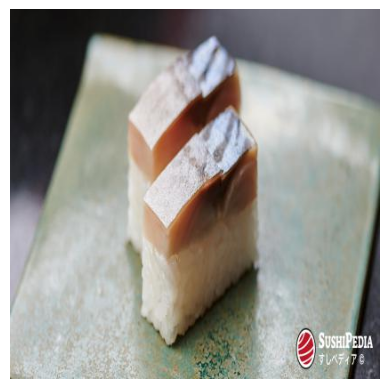

No boxes even at low conf.


In [ ]:
img = "/content/drive/MyDrive/yolo-susho-detection-data/valid/images/saba_04_jpg.rf.9bf121ff6c7346a64d99839b988e02fe.jpg"

# Drop thresholds to see if *anything* fires
results = model(img, conf=0.01, iou=0.7, imgsz=416, verbose=True)

# Visualize
import matplotlib.pyplot as plt
for r in results:
    im = r.plot()[..., ::-1]
    plt.imshow(im); plt.axis("off"); plt.show()

# Print detected boxes: class id, confidence, xyxy
for r in results:
    if r.boxes is not None and len(r.boxes) > 0:
        print("classes:", r.boxes.cls.tolist())
        print("confs  :", r.boxes.conf.tolist())
        print("xyxy   :", r.boxes.xyxy.tolist())
    else:
        print("No boxes even at low conf.")

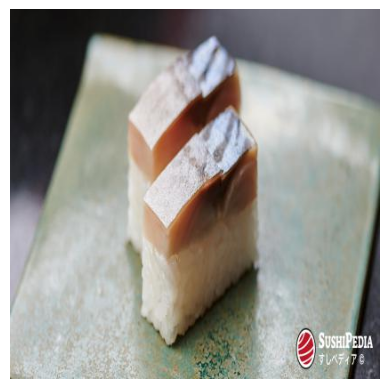

In [ ]:
import matplotlib.pyplot as plt

for r in results:
    im_array = r.plot()  # plot returns a numpy array (BGR)
    plt.imshow(im_array[..., ::-1])  # convert BGR to RGB
    plt.axis("off")
    plt.show()